In [1]:
!pip install pytorch-lightning pandas xarray torchist xskillscore pyyaml zarr tqdm

In [2]:
# Step 2: Add your ChaosBench project to Python path
import sys
sys.path.append(r"C:\Users\brand\OneDrive\Desktop\chaosbench-20250319T123539Z-001\chaosbench")  # Adjust this path if needed

In [3]:
# Step 3: Import required modules from ChaosBench and other libraries
import os
import torch
import yaml
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint

import dataset, config, utils, criterion
from models.model import S2SBenchmarkModel

# Set device (uses CUDA if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\brand\anaconda3\envs\torch_cuda_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Step 4: Load the pretrained model checkpoint
# Adjust the following paths to match your checkpoint and config locations.
log_dir = Path(r"C:\Users\brand\OneDrive\Desktop\chaosbench-20250319T123539Z-001\chaosbench\logs\lightning_logs\version_28")  # Change to your logs directory
ckpt_dir = log_dir / r"C:\Users\brand\OneDrive\Desktop\ChaosBench-20250319T123531Z-001\ChaosBench\checkpoints"       # Change version if needed
ckpt_files = list(ckpt_dir.glob('*.ckpt'))
assert len(ckpt_files) > 0, "No checkpoint found in the specified directory!"
ckpt_filepath = ckpt_files[0]  # Use the first checkpoint (or modify as needed)

# Load model configuration (YAML)
config_filepath = Path(r"C:\Users\brand\OneDrive\Desktop\chaosbench-20250319T123539Z-001\chaosbench\configs\fno_pinn.yaml")  # Adjust the path
with open(config_filepath, 'r') as config_f:
    hyperparams = yaml.load(config_f, Loader=yaml.FullLoader)

model_args = hyperparams['model_args']
data_args = hyperparams['data_args']

baseline = S2SBenchmarkModel.load_from_checkpoint(
    str(ckpt_filepath),
    model_args=model_args,
    data_args=data_args
)

baseline.eval()  # Set model to evaluation mode
baseline.to(device)

S2SBenchmarkModel(
  (model): FNO2d(
    (fc0): Linear(in_features=48, out_features=64, bias=True)
    (conv0): SpectralConv2d_fast()
    (conv1): SpectralConv2d_fast()
    (conv2): SpectralConv2d_fast()
    (conv3): SpectralConv2d_fast()
    (w0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (w1): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    (w2): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
    (w3): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1))
    (decoder): Sequential(
      (0): Conv2d(1024, 48, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (transformer): Sequential(
    (0): CustomTransformerBlock(
      (attn): PreNorm(
        (fn): EfficientSelfAttention(
          (to_q): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (to_kv): Conv2d(48, 96, kernel_size=(4, 4), stride=(4, 4), bias=False)
          (to_out): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (norm): LayerNorm()
      )
 

In [5]:
# Step 5: Prepare the evaluation dataset
BATCH_SIZE = 8
eval_years = [2020]  # Change as needed

# Load the evaluation dataset. This example uses S2SObsDataset.
input_dataset = dataset.CSV_ERA5_Dataset(
    years=eval_years,
    n_step=config.N_STEPS - 1,  # e.g., if N_STEPS=45, then we have 44 prediction steps
    lead_time=1,                # Adjust if needed
    land_vars=data_args.get('land_vars', []),
    ocean_vars=data_args.get('ocean_vars', [])
)
input_dataloader = DataLoader(input_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [6]:
print("Number of samples in dataset:", len(input_dataset))


Number of samples in dataset: 322


In [7]:
# Step 6: Perform iterative (autoregressive) inference
# Initialize evaluation metrics (examples: RMSE, Bias)
RMSE_metric = criterion.RMSE()
Bias_metric = criterion.Bias()
# ACC_metric = criterion.ACC()

all_rmse = []   # List to store RMSE for each batch and timestep
all_bias = []   # List to store Bias for each batch and timestep
# all_acc  = []   # List to store ACC for each batch and timestep

for batch_idx, (timestamp, preds_x, preds_y) in enumerate(tqdm(input_dataloader, desc="Evaluating")):
    # Move input to device
    preds_x = preds_x.to(device)
    preds_y = preds_y.to(device)  # Ground truth shape: (BATCH_SIZE, timesteps, output_dim)

    batch_rmse = []
    batch_bias = []
    # batch_acc  = []

    # Iterate over the number of prediction time steps (autoregressive)
    # For each time step, run inference and update predictions.
    for step_idx in range(preds_y.size(1)):
        with torch.no_grad():
            preds = baseline(preds_x)  # Forward pass
        # Assume the model outputs predictions with shape matching targets: (BATCH_SIZE, channels, H, W)
        targets = preds_y[:, step_idx]

        # Compute global metrics (over all channels)
        rmse_val = RMSE_metric(preds, targets).cpu().numpy()
        bias_val = Bias_metric(preds, targets).cpu().numpy()

        # --- Compute denormalized metrics for specific channels ---
        # For u-1000 (channel index 36)
        preds_u1000 = preds[:, 36]
        targets_u1000 = targets[:, 36]

        preds_u1000_np = preds_u1000.cpu().numpy()
        targets_u1000_np = targets_u1000.cpu().numpy()

        denorm_preds_u1000 = utils.denormalize(preds_u1000_np, 'u-1000', 'era5', is_diff=False)
        denorm_targets_u1000 = utils.denormalize(targets_u1000_np, 'u-1000', 'era5', is_diff=False)

        denorm_preds_u1000 = torch.tensor(denorm_preds_u1000, device=device)
        denorm_targets_u1000 = torch.tensor(denorm_targets_u1000, device=device)

        rmse_u1000 = RMSE_metric(denorm_preds_u1000, denorm_targets_u1000).cpu().numpy()

        # For v-1000 (channel index 46)
        preds_v1000 = preds[:, 46]
        targets_v1000 = targets[:, 46]

        preds_v1000_np = preds_v1000.cpu().numpy()
        targets_v1000_np = targets_v1000.cpu().numpy()

        denorm_preds_v1000 = utils.denormalize(preds_v1000_np, 'v-1000', 'era5', is_diff=False)
        denorm_targets_v1000 = utils.denormalize(targets_v1000_np, 'v-1000', 'era5', is_diff=False)

        denorm_preds_v1000 = torch.tensor(denorm_preds_v1000, device=device)
        denorm_targets_v1000 = torch.tensor(denorm_targets_v1000, device=device)

        rmse_v1000 = RMSE_metric(denorm_preds_v1000, denorm_targets_v1000).cpu().numpy()
        # --- End denormalized metrics ---

        # Store your metrics as desired, for example as a tuple:
        batch_rmse.append((rmse_val, rmse_u1000, rmse_v1000))
        batch_bias.append(bias_val)

        # Autoregressive update:
        preds_x = preds

    all_rmse.append(batch_rmse)
    all_bias.append(batch_bias)


Evaluating: 100%|██████████| 41/41 [00:52<00:00,  1.29s/it]


In [8]:
!pip install matplotlib

In [9]:
import pandas as pd

df = pd.read_csv("rmse_graphcast.csv", header=None)  # or header=some_row if you know there's a header row
print(df.head())


    0                   1                   2                   3    \
0  z-10                z-50               z-100               z-200   
1   NaN   16.15295294179277  12.809589522794012  13.351289704355231   
2   NaN  22.280528119688512  16.934657505537587  16.942449670774447   
3   NaN  28.581447710578768  21.986253432051072  22.369786934137267   
4   NaN  35.722041509519165  28.269349917574438  29.960064124460075   

                  4                   5                   6    \
0               z-300               z-500               z-700   
1  13.388047433164587   9.777885501014794  7.6411706518064655   
2  16.654101979063395   11.92063070316163   9.383122390580434   
3  22.439246608716488  15.933837761027245  12.458435046599796   
4  30.960252873145738   22.25703451651481   17.25706255931931   

                  7                   8                   9    ...       114  \
0               z-850               z-925              z-1000  ...  sohtc700   
1    7.26332687257246 

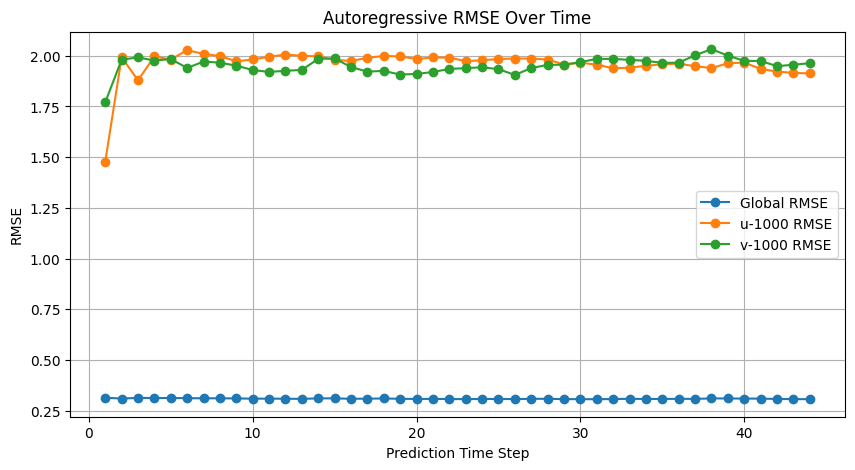

In [10]:
# Plot RMSE over time steps (averaged over batches)
import matplotlib.pyplot as plt

# Convert all_rmse (a list of lists of tuples) to separate NumPy arrays
# Each element in all_rmse is a list (for each batch) of tuples (global, u-1000, v-1000) for each timestep.
all_rmse = np.array(all_rmse)  # shape (num_batches, num_timesteps, 3)

# Compute mean across batches for each metric separately.
mean_global = np.nanmean(all_rmse[:, :, 0], axis=0)
mean_u1000 = np.nanmean(all_rmse[:, :, 1], axis=0)
mean_v1000 = np.nanmean(all_rmse[:, :, 2], axis=0)

# Plotting each RMSE time series
import matplotlib.pyplot as plt

timesteps = np.arange(1, mean_global.size + 1)
plt.figure(figsize=(10, 5))
plt.plot(timesteps, mean_global, marker='o', label='Global RMSE')
plt.plot(timesteps, mean_u1000, marker='o', label='u-1000 RMSE')
plt.plot(timesteps, mean_v1000, marker='o', label='v-1000 RMSE')
plt.xlabel("Prediction Time Step")
plt.ylabel("RMSE")
plt.title("Autoregressive RMSE Over Time")
plt.legend()
plt.grid(True)
plt.show()
